### This notebook will load the individual connectivty weights and analyze the `coef_var`

In [1]:
import cortico_cereb_connectivity.globals as gl
import cortico_cereb_connectivity.run_model as rm
import Functional_Fusion.dataset as fdata
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
def load_coef_var(train_types, method='L2reg'):
    var_dic = {'subj_id': [],
            'coef_var': [],
            'logalpha': [],
            'train_dataset': [],
            'coef_norm': []}
    for dataset_name, (sess, la) in train_types.items():
        print('--------------------')
        print(f"Loading {dataset_name} {sess} {la}")
        config = rm.get_eval_config(eval_dataset=dataset_name, eval_ses=sess, model='ind', cerebellum='MNISymC3', add_rest=True)
        dataset = fdata.get_dataset_class(gl.base_dir, dataset=dataset_name)
        config["subj_list"] = dataset.get_participants().participant_id

        dirname=[]
        mname=[]
        dirname.append(f"{dataset_name}_{sess}_Icosahedron1002_{method}")
        mname.append(f"{dataset_name}_{sess}_Icosahedron1002_{method}_A{la}")

        fm,_ = rm.get_fitted_models(dirname,mname,config)
        fm = fm[0]
        print(f"Loaded {len(fm)} models, reading coef_var ...")
        for conn_model in fm:
            var_dic['coef_var'].append(np.nanmean(conn_model.coef_var))
            var_dic['coef_norm'].append(np.linalg.norm(np.nan_to_num(conn_model.coef_), ord='fro'))
        var_dic['subj_id'].extend(config["subj_list"])
        var_dic['logalpha'].extend([la]*(len(var_dic['coef_var'])-len(var_dic['logalpha'])))
        var_dic['train_dataset'].extend([dataset_name]*(len(var_dic['coef_var'])-len(var_dic['train_dataset'])))

    var_df = pd.DataFrame(var_dic)
    return var_df

In [6]:
dataset_list = ["MDTB", "Language", "WMFS", "Demand", "Somatotopic", "Nishimoto", "IBC"]
logalpha_list = [8, 8, 8, 8, 8, 10, 8]
train_types = {}
for dataset_name, la in zip(dataset_list, logalpha_list):
    if dataset_name == 'Language':
        train_types[dataset_name] = ('ses-localizer_cond', la)
    else:
        train_types[dataset_name] = ('all', la)

In [8]:
# var_df = load_coef_var(train_types)
# var_df.to_csv('/home/UWO/ashahb7/Github/bayes_temp/L2reg_df.tsv', sep='\t', index=False)
var_df = load_coef_var(train_types, method='L2reg2')
var_df.to_csv('/home/UWO/ashahb7/Github/bayes_temp/L2reg2_df.tsv', sep='\t', index=False)

--------------------
Loading MDTB all 8
Loaded 24 models, reading coef_var ...
--------------------
Loading Language ses-localizer_cond 8
Loaded 17 models, reading coef_var ...
--------------------
Loading WMFS all 8
Loaded 16 models, reading coef_var ...
--------------------
Loading Demand all 8
Loaded 37 models, reading coef_var ...
--------------------
Loading Somatotopic all 8
Loaded 8 models, reading coef_var ...
--------------------
Loading Nishimoto all 10
Loaded 6 models, reading coef_var ...
--------------------
Loading IBC all 8
Loaded 12 models, reading coef_var ...


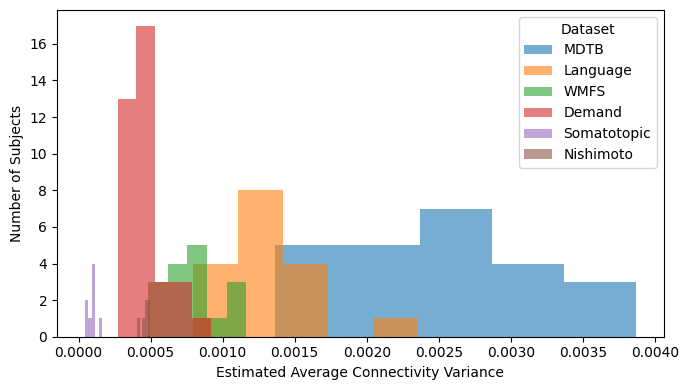

dummy_column,dummy_value
dataset,
Demand,3.379707
Language,2.973258
MDTB,2.831735
Nishimoto,1.214321
Somatotopic,3.926712
WMFS,2.403934


Variance Width: 91.59062874818368


In [28]:
var_df = pd.read_csv('/home/UWO/ashahb7/Github/bayes_temp/var_df.tsv', sep='\t')
plt.figure(figsize=(7,4))
for dataset_name in var_df.train_dataset.unique():
    plt.hist(var_df[var_df.train_dataset == dataset_name].coef_var, bins=5, alpha=0.6, label=dataset_name)
plt.xlabel('Estimated Average Connectivity Variance')
plt.ylabel('Number of Subjects')
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

dataset_variance_widths = var_df.groupby(['train_dataset'])['coef_var'].apply(lambda x: x.max() / x.min()).reset_index()
dataset_variance_widths.columns = ['dataset', 'variance_width']
dataset_variance_widths['dummy_column'] = 'dummy_value'
display(dataset_variance_widths.pivot(index='dataset', columns='dummy_column', values='variance_width'))

variance_widths = var_df['coef_var'].max() / var_df['coef_var'].min()
print(f"Variance Width: {variance_widths}")

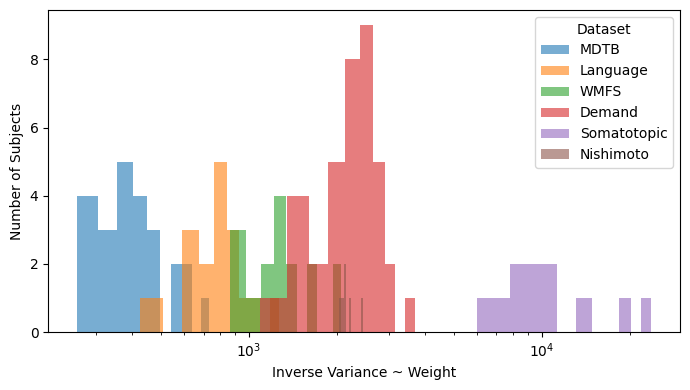

In [30]:
plt.figure(figsize=(7,4))
for dataset_name in var_df.train_dataset.unique():
    plt.hist(1/var_df[var_df.train_dataset == dataset_name].coef_var, alpha=0.6, label=dataset_name)
plt.xlabel('Inverse Variance ~ Weight')
plt.ylabel('Number of Subjects')
plt.legend(title='Dataset')
plt.xscale('log')
plt.tight_layout()
plt.show()

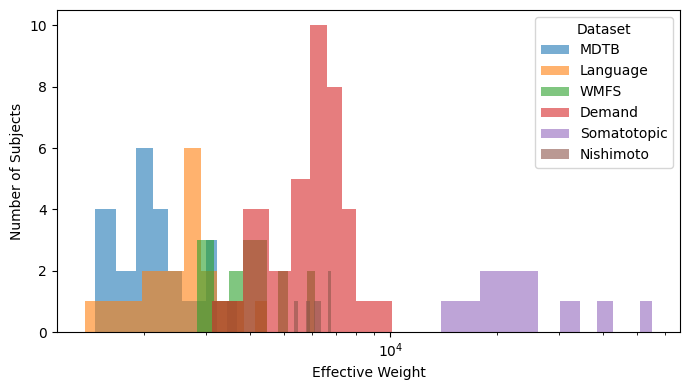

,weight_width
dataset,
Demand,3.235863
Language,3.261387
MDTB,2.531049
Nishimoto,1.271873
Somatotopic,3.961913
WMFS,2.165336


Weight Width: 40.193421044416915


In [35]:
plt.figure(figsize=(7,4))
for dataset_name in var_df.train_dataset.unique():
    plt.hist(var_df[var_df.train_dataset == dataset_name].effective_weight, alpha=0.6, label=dataset_name)
plt.xlabel('Effective Weight')
plt.ylabel('Number of Subjects')
plt.legend(title='Dataset')
plt.xscale('log')
plt.tight_layout()
plt.show()

dataset_widths = var_df.groupby(['train_dataset'])['effective_weight'].apply(lambda x: x.max() / x.min()).reset_index()
dataset_widths.columns = ['dataset', 'weight_width']
display(dataset_widths.set_index('dataset'))

weight_widths = var_df['effective_weight'].max() / var_df['effective_weight'].min()
print(f"Weight Width: {weight_widths}")
